Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [9]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.144497
Minibatch accuracy: 18.8%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.042096
Minibatch accuracy: 56.2%
Validation accuracy: 39.5%
Minibatch loss at step 100: 0.687427
Minibatch accuracy: 75.0%
Validation accuracy: 51.4%
Minibatch loss at step 150: 1.168226
Minibatch accuracy: 75.0%
Validation accuracy: 56.7%
Minibatch loss at step 200: 0.875445
Minibatch accuracy: 81.2%
Validation accuracy: 59.3%
Minibatch loss at step 250: 1.082195
Minibatch accuracy: 75.0%
Validation accuracy: 57.9%
Minibatch loss at step 300: 1.161536
Minibatch accuracy: 68.8%
Validation accuracy: 58.8%
Minibatch loss at step 350: 0.509612
Minibatch accuracy: 87.5%
Validation accuracy: 62.0%
Minibatch loss at step 400: 1.032709
Minibatch accuracy: 81.2%
Validation accuracy: 60.9%
Minibatch loss at step 450: 0.550442
Minibatch accuracy: 87.5%
Validation accuracy: 64.8%
Minibatch loss at step 500: 0.658947
Minibatch accuracy: 81.2%
Validation accuracy: 62.2%
M

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [19]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  optimizer = tf.train.AdamOptimizer().minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [20]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.732943
Minibatch accuracy: 6.2%
Validation accuracy: 9.8%
Minibatch loss at step 50: 1.914641
Minibatch accuracy: 25.0%
Validation accuracy: 35.7%
Minibatch loss at step 100: 0.756335
Minibatch accuracy: 81.2%
Validation accuracy: 53.0%
Minibatch loss at step 150: 1.229692
Minibatch accuracy: 68.8%
Validation accuracy: 53.9%
Minibatch loss at step 200: 1.037723
Minibatch accuracy: 81.2%
Validation accuracy: 59.2%
Minibatch loss at step 250: 1.329782
Minibatch accuracy: 75.0%
Validation accuracy: 62.6%
Minibatch loss at step 300: 1.134509
Minibatch accuracy: 56.2%
Validation accuracy: 61.3%
Minibatch loss at step 350: 0.770173
Minibatch accuracy: 87.5%
Validation accuracy: 62.9%
Minibatch loss at step 400: 1.122269
Minibatch accuracy: 75.0%
Validation accuracy: 62.4%
Minibatch loss at step 450: 0.601667
Minibatch accuracy: 81.2%
Validation accuracy: 66.4%
Minibatch loss at step 500: 0.856818
Minibatch accuracy: 75.0%
Validation accuracy: 64.7%
Min

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

Model designed using dropout

In [17]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def modelTrain(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    print(conv1)
    print(layer1_weights)
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    drop1 = tf.nn.dropout(pool1, 0.5)
    
    conv2 = tf.nn.conv2d(drop1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    print(conv2)
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    drop2 = tf.nn.dropout(pool2, 0.5)
    
    shape = drop2.get_shape().as_list()
    reshape = tf.reshape(drop2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases

  def modelTest(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = modelTrain(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  optimizer = tf.train.AdamOptimizer().minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelTest(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelTest(tf_test_dataset))

Tensor("Conv2D:0", shape=(16, 28, 28, 16), dtype=float32)
Tensor("Variable/read:0", shape=(5, 5, 1, 16), dtype=float32)
Tensor("Conv2D_1:0", shape=(16, 14, 14, 16), dtype=float32)


In [11]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.866991
Minibatch accuracy: 12.5%
Validation accuracy: 10.3%
Minibatch loss at step 50: 2.521278
Minibatch accuracy: 12.5%
Validation accuracy: 11.3%
Minibatch loss at step 100: 2.082868
Minibatch accuracy: 18.8%
Validation accuracy: 22.5%
Minibatch loss at step 150: 1.682335
Minibatch accuracy: 43.8%
Validation accuracy: 31.3%
Minibatch loss at step 200: 1.596248
Minibatch accuracy: 50.0%
Validation accuracy: 40.1%
Minibatch loss at step 250: 1.884851
Minibatch accuracy: 56.2%
Validation accuracy: 51.6%
Minibatch loss at step 300: 1.552370
Minibatch accuracy: 43.8%
Validation accuracy: 53.9%
Minibatch loss at step 350: 0.788536
Minibatch accuracy: 75.0%
Validation accuracy: 55.3%
Minibatch loss at step 400: 1.327368
Minibatch accuracy: 68.8%
Validation accuracy: 58.1%
Minibatch loss at step 450: 1.426111
Minibatch accuracy: 43.8%
Validation accuracy: 59.8%
Minibatch loss at step 500: 1.693400
Minibatch accuracy: 50.0%
Validation accuracy: 57.5%
M

Model designed using 5X5 convolution, pooling followed by 5x5 convolution, pooling and finally a fully connected layer with 64 neurons 

In [7]:
batch_size = 16
patch_size = 5
depth = 14
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))    # [5, 5, 1, 14]
  layer1_biases = tf.Variable(tf.truncated_normal([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(     
      [patch_size, patch_size, depth, depth], stddev=0.1))           # [5, 5, 14, 28]  
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size//4 * image_size//4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.avg_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.avg_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  optimizer = tf.train.AdamOptimizer().minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [9]:
num_steps = 15001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.427645
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.245952
Minibatch accuracy: 12.5%
Validation accuracy: 13.0%
Minibatch loss at step 100: 1.695200
Minibatch accuracy: 37.5%
Validation accuracy: 38.3%
Minibatch loss at step 150: 1.252712
Minibatch accuracy: 68.8%
Validation accuracy: 43.5%
Minibatch loss at step 200: 1.168112
Minibatch accuracy: 75.0%
Validation accuracy: 55.0%
Minibatch loss at step 250: 1.267542
Minibatch accuracy: 75.0%
Validation accuracy: 62.2%
Minibatch loss at step 300: 1.290528
Minibatch accuracy: 56.2%
Validation accuracy: 62.7%
Minibatch loss at step 350: 0.611996
Minibatch accuracy: 87.5%
Validation accuracy: 64.8%
Minibatch loss at step 400: 1.081666
Minibatch accuracy: 75.0%
Validation accuracy: 61.5%
Minibatch loss at step 450: 0.732446
Minibatch accuracy: 81.2%
Validation accuracy: 65.1%
Minibatch loss at step 500: 0.968014
Minibatch accuracy: 75.0%
Validation accuracy: 63.6%
Mi

Demonstrating model to show dropout does not work on convolutional layer.


In [23]:
batch_size = 16
patch_size = 5
depth = 14
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))    # [5, 5, 1, 14]
  layer1_biases = tf.Variable(tf.truncated_normal([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(     
      [patch_size, patch_size, depth, depth], stddev=0.1))           # [5, 5, 14, 28]  
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size//4 * image_size//4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    drop = tf.nn.dropout(hidden, 0.5)
    
    return tf.matmul(drop, layer4_weights) + layer4_biases

  def modelTest(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  optimizer = tf.train.AdamOptimizer().minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelTest(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelTest(tf_test_dataset))

In [25]:
num_steps = 15001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.284821
Minibatch accuracy: 12.5%
Validation accuracy: 10.1%
Minibatch loss at step 50: 2.345907
Minibatch accuracy: 6.2%
Validation accuracy: 10.6%
Minibatch loss at step 100: 2.374837
Minibatch accuracy: 6.2%
Validation accuracy: 14.8%
Minibatch loss at step 150: 2.110399
Minibatch accuracy: 25.0%
Validation accuracy: 15.8%
Minibatch loss at step 200: 1.887661
Minibatch accuracy: 37.5%
Validation accuracy: 37.6%
Minibatch loss at step 250: 1.955488
Minibatch accuracy: 18.8%
Validation accuracy: 53.2%
Minibatch loss at step 300: 1.304958
Minibatch accuracy: 68.8%
Validation accuracy: 56.6%
Minibatch loss at step 350: 0.888772
Minibatch accuracy: 68.8%
Validation accuracy: 59.4%
Minibatch loss at step 400: 1.473631
Minibatch accuracy: 50.0%
Validation accuracy: 58.4%
Minibatch loss at step 450: 1.329865
Minibatch accuracy: 62.5%
Validation accuracy: 58.0%
Minibatch loss at step 500: 1.472599
Minibatch accuracy: 50.0%
Validation accuracy: 59.1%
Min

In [39]:
batch_size = 16
patch_size = 5
depth = 14
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))    # [5, 5, 1, 14]
  layer1_biases = tf.Variable(tf.truncated_normal([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(     
      [patch_size, patch_size, depth, depth], stddev=0.1))           # [5, 5, 14, 28]  
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size//4 * image_size//4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    drop = tf.nn.dropout(hidden, 0.5)
    
    return tf.matmul(drop, layer4_weights) + layer4_biases

  def modelTest(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  #optimizer = tf.train.AdamOptimizer().minimize(loss)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(modelTest(tf_valid_dataset))
  test_prediction = tf.nn.softmax(modelTest(tf_test_dataset))

In [40]:
num_steps = 1001
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
accuracy_test = []
accuracy_valid = []

for rate in learning_rates:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      valid_sum = []
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, learning_rate : rate}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
           valid_sum.append(accuracy(valid_prediction.eval(), valid_labels))
      accuracy_valid.append(np.mean(valid_sum))
      accuracy_test.append(accuracy(test_prediction.eval(), test_labels))
    print(rate, " completed")

0.001  completed
0.005  completed
0.01  completed
0.05  completed
0.1  completed
0.5  completed


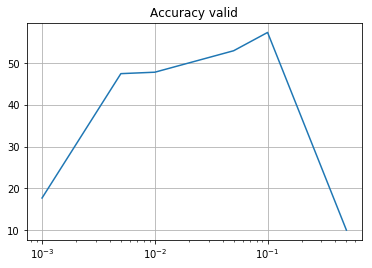

In [57]:
plt.semilogx(learning_rates, accuracy_valid)
plt.grid(True)
plt.title('Accuracy valid')
plt.show()

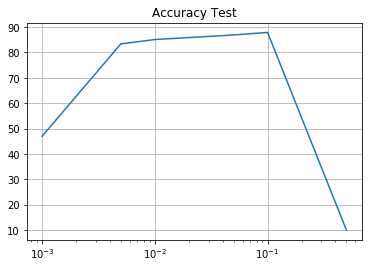

In [56]:
plt.semilogx(learning_rates, accuracy_test)
plt.grid(True)
plt.title('Accuracy Test')
plt.show()

In [58]:
num_steps = 15001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, learning_rate : 0.1}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.184390
Minibatch accuracy: 25.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.846732
Minibatch accuracy: 31.2%
Validation accuracy: 22.3%
Minibatch loss at step 100: 1.339309
Minibatch accuracy: 56.2%
Validation accuracy: 45.6%
Minibatch loss at step 150: 1.284660
Minibatch accuracy: 50.0%
Validation accuracy: 53.6%
Minibatch loss at step 200: 0.980369
Minibatch accuracy: 62.5%
Validation accuracy: 57.6%
Minibatch loss at step 250: 1.110217
Minibatch accuracy: 68.8%
Validation accuracy: 56.5%
Minibatch loss at step 300: 1.378198
Minibatch accuracy: 50.0%
Validation accuracy: 53.7%
Minibatch loss at step 350: 0.678970
Minibatch accuracy: 81.2%
Validation accuracy: 58.9%
Minibatch loss at step 400: 1.147608
Minibatch accuracy: 68.8%
Validation accuracy: 61.3%
Minibatch loss at step 450: 0.682837
Minibatch accuracy: 81.2%
Validation accuracy: 60.5%
Minibatch loss at step 500: 0.966087
Minibatch accuracy: 68.8%
Validation accuracy: 63.3%
M

A simple model with two convolutional-average pooling layer and a dense layer network gives better accuracy(95.5%).
This model should be further refined to get better accuracy!